# This is just a notebook to visualise 1kHz filtered raw data

## Setup everything

### Import packages

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, InMemoryAnalogSignalSource, EventList
from ephyviewer import AnalogSignalSourceWithScatter, SpikeInterfaceRecordingSource, InMemoryEventSource

# add the Contrib dir that contains all tools developped by MB : mbTools.py
#sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'python'))
#print(os.path.join(os.path.dirname(sys.path[0]),'python'))
from mbTools import mbTools

import configparser
import json
import ast


### Import local config, create it if inexistant
All user-specific configuration (projects, defautl path to files...) are stored in a file named localConfig.ini in the python subfolder of AudreyHayLab repo. It is ignored by git so that it remains truely local. If the file does not exist at beginning, it is created with default values that can be modified at whishes.

In [2]:
config = mbTools.localConf()
rawDataPath = config['DATA']['path']
print(f'All raw data are expected to be found in the folder: {rawDataPath}')
analysisPath = config['ANALYSIS']['path']
print(f'All analysis will be saved in the folder: {analysisPath}')
config.printAll()

Local config file loaded from localConfig.ini
All raw data are expected to be found in the folder: C:\Users\Manip1
All analysis will be saved in the folder: C:\Users\Manip1\Analysis
DATA
[('path', 'C:\\Users\\Manip1')]
ANALYSIS
[('path', 'C:\\Users\\Manip1\\Analysis'),
 ('projecttype', '0'),
 ('animalid', '0'),
 ('projectid', 'AProject'),
 ('subprojectid', 'OneOfItsSubProject'),
 ('conditionid', 'control'),
 ('recordingid', '0'),
 ('suffix', '')]
AProject.OneOfItsSubProject
[('design', '0'),
 ('nanimal', '6'),
 ('conditions', "['control']"),
 ('nrecordings', '1')]


## Choose experiment
Select the experiment to display. If the experiment was already analyzed, a saved_dictionary.pkl was created and contains all necessary variables. Select this file. Otherwise select the raw data recording file.
>**If you have a file with channel mapping somewhere**, we should make sure it is properly translated into a dict.pkl

In [3]:
currentFile = None
%store -r currentFile
print(currentFile)
try:
    theExpe = mbTools.expeConfigDict(currentFile)
except Exception as error:
    print(error)
    theExpe = mbTools.expeConfigDict()

C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0\saved_dictionary.pkl
Local config file loaded from localConfig.ini
the file is C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0\saved_dictionary.pkl


FileChooser(path='C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0', filename='saved_dictionary.…

### Possibility to change raw data path 
if for some reason the path to the raw data is wrong, you can update it here

In [4]:
theExpe.rawDataSelector()

FileChooser(path='C:\Users\Manip1\Documents\MB\HayLabAnalysis\python', filename='', title='<b>ePhys data</b>',…

## Load Data

### Map the whole data into memory

In [5]:
if False:
    dpath = None #  '//10.69.168.1/crnldata/waking/audrey_hay/NPX/NPX4_claustrum/Expe_2024-07-18_12-00-43/'
    # %store dpath
    %store -r dpath
    print(dpath)
    theExpe.rawDataPath = dpath
print(theExpe.rawDataPath)
thedata = mbTools.experiment(theExpe)

\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\


FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29', filena…

In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
thedata.analyseExpe_findData()

\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29
found some .bin files
data recorded with Bonsai
importing \\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\OE_32ch_data_2024-07-20T12_45_29.bin
applying offset
converting to int16
IntanLFP file loaded, with 32 channels and 106671104 datapoint
found some NPX files
the calculated sampling rate is 30070.243213822876 Hz
launch start would be 2024-07-20 12:45:29.896598+02:00
the interval to first clock is 0.041224
the first timestamp for 10306075 samples, corresponding to 0.041224 s, would be 2024-07-20 12:45:29.937822+02:00
there are 161553312 timestamps
the calculated sampling rate is 30070.243213822876 Hz
launch start would be 2024-07-20 12:45:29.896598+02:00
the interval to first clock is 0.041224
the first timestamp for 10306075 samples, corresponding to 0.041224 s, would be 2024-07-20 12:45:29.937822+02:00
there are 161553312 timestamps


### Extract submatrix of interest

In [7]:
#initiate combined and channelLabels
combined =  {}
channelLabels = {}
sample_rates = {}
t_start = {}
#t_end = 300 #seconds

In [8]:
expeConfigFN=os.path.sep.join([theExpe.rawDataPath,'expeConfig.ini'])
parser = configparser.ConfigParser()
parser.read(expeConfigFN)

if os.path.isfile(expeConfigFN):
    print('mapping exists so loading it')
    thedata.data['OE_LFP'].channelsMap = ast.literal_eval(parser['OE_LFP']['channelsMap'])
    thedata.data['OE_LFP'].start=ast.literal_eval(parser['OE_LFP']['start'])
    thedata.data['OE_LFP'].sampling_rate=ast.literal_eval(parser['OE_LFP']['freq'])
else:
    print("mapping doesn't exist so generating it")
    thedata.data['OE_LFP'].channelsMap = dict( \
            M1 = [dict(canal = 17, status=1),
                dict(canal = 16, status=2)],
        )

    parser['OE_LFP'] = {'channelsMap': thedata.data['OE_LFP'].channelsMap}


    artefacts=[55.2, 88.74, 90.6, 121.18, 123, 188, 268, 2065, 3036, 3754, 3590]
    parser['OE_LFP']['artefacts']=str(artefacts)


    parser['OE_LFP']['start']=str(52.7137)

    with open(expeConfigFN, 'w') as configfile:
        parser.write(configfile)

print("the mapping:", thedata.data['OE_LFP'].channelsMap)
print("the offset: ", thedata.data['OE_LFP'].start)
print("the sampling rate: ", thedata.data['OE_LFP'].sampling_rate)

thedata.data['OE_LFP'].reAlignTimes()


mapping exists so loading it
the mapping: {'M1': [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]}
the offset:  51.44846048
the sampling rate:  20046.76684681


### Extract submatrix of interest

In [14]:
#LFP
if 'OE_LFP' in thedata.data:
    sample_rates['LFP'] = thedata.data['OE_LFP'].sampling_rate #20000
    t_start['LFP'] = thedata.data['OE_LFP'].start
    combined['LFP'] = thedata.data['OE_LFP'].combineStructures(['M1'])
    channelLabels['LFP'] = thedata.data['OE_LFP'].channelLabels[:]
    print("LFP data combined")
else:
    print("no LFP data to combine")

M1 -> [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]
Getting differential signal of channel 16 - channel 17 for M1
LFP data combined


In [10]:
#NPX
if 'NPX' in thedata.data:
    sample_rates['NPX'] = thedata.data['NPX'].sampling_rate #30000
    t_start['NPX'] = thedata.data['NPX'].start
    combined['NPX'] = thedata.data['NPX'].signal['spike']
    channelLabels['NPX'] = thedata.data['NPX'].channelLabels
    print("NPX data combined")
else:
    print("no NPX data to combine")

NPX data combined


### Load extra stuff

In [11]:
from mbTools import mbTools
try:
    All_Spindle, M1 = thedata.data['OE_LFP'].loadSpindles(relativePath='../LFP', structure = "M1")
    combined['LFP_DS']=M1[:,np.newaxis]
    channelLabels['LFP_DS'] = ['M1_DS']
    freqInitTheoric=20000
    freqDS=1000
    realignFactor=freqInitTheoric/sample_rates['LFP']
    sample_rates['LFP_DS']=freqDS*realignFactor
    t_start['LFP_DS']=t_start['LFP']
    print(realignFactor)
except Exception as error:
    print(error)

file \\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\../LFP\Spindlesproperties_M1.csv doesn't exist yet which is probably because you haven't done the analysis or the relative path is wrong
no file \\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\../LFP\SignalM1.npy was found, please make sure it exists
cannot access local variable 'signal' where it is not associated with a value


55.00000578461223
71197
M1 -> [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]
Getting differential signal of channel 16 - channel 17 for M1
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
1652612


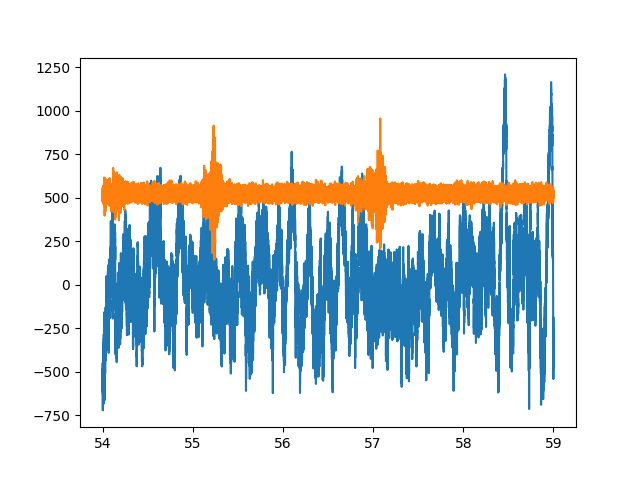

In [30]:
#this cell can be used to plot very precisely time of interest. Beware that it conflicts with ephyviewer however. It might be possible to have 2 notebooks open simultanéeously...
if False:
    %matplotlib widget
    #you can confiure a y-offset and some scaling, have a look at the help of superCleanPlot
    mbTools.superCleanPlot(thedata.data['OE_LFP'], thedata.data['NPX'], structureLFP=['M1'], canauxNPX=[0], time=55) #canauxLFP=16, 
    picFN = os.path.sep.join([theExpe.rawDataPath,'A1-8978.svg'])
    plt.savefig(picFN, format="svg")

## Display

In [ ]:
%gui qt
app = mkQApp()


try:
    TTL = Timestamps

    #create 2 familly scatters from theses 2 indexes
    scatter_indexes = {0: TTL, 1: TTL}
    #and asign them to some channels each
    scatter_channels = {0: [0, 12], 1: [0, 1]}
    #source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)
except Exception:
    pass

#Create the main window that can contain several viewers
win = MainViewer(debug=True)

if 'LFP' in combined:
    source = InMemoryAnalogSignalSource(combined['LFP'], np.round(sample_rates['LFP']), t_start['LFP'], channel_names=channelLabels['LFP'])
    view1 = TraceViewer(source=source, name = 'LFP')

    #Parameters can be set in script
    view1.params['display_labels'] = True
    view1.params['scale_mode'] = 'same_for_all'
    view1.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view1.by_channel_params.children())
    for ch in range(nCh):
        #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view1.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view1.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    #create a time freq viewer conencted to the same source
    view2 = TimeFreqViewer(source=source, name='tfr')
    view2.params['show_axis'] = False
    view2.params['timefreq', 'deltafreq'] = 1
    #view2.by_channel_params['ch3', 'visible'] = False
    view2.auto_scale()

    win.add_view(view1)
    #win.add_view(view2)

if False:#'LFP_DS' in combined:

    if All_Spindle is not None:
        #Create one data source with 3 event channel
        all_events = []
        conditions = ['All','Good','Bad']
        for c,cond in enumerate(conditions):
            match cond:
                case 'All':
                    selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
                case 'Good':
                    selection = "All_Spindle['toKeep']"
                case 'Bad':
                    selection = "~All_Spindle['toKeep']"
            ev_times = mbTools.convertTheoricIndex2realTime(All_Spindle.loc[pd.eval(selection),'peak time'].values, realFreq=sample_rates['LFP_DS'], offset=t_start['LFP_DS'])
            ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
            all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
        source_ev = InMemoryEventSource(all_events=all_events)

        Spindle_peak = All_Spindle['peak time'].astype(int)
        Spindle_start = All_Spindle['start time'].astype(int)
        Spindle_end = All_Spindle['end time'].astype(int)

        #create 2 familly scatters from theses 2 indexes
        scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
        #and asign them to some channels each
        scatter_channels = {0: [0], 1: [0], 2: [0]}
        source = AnalogSignalSourceWithScatter(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], scatter_indexes, scatter_channels)#, channel_names=channelLabels['LFP_DS']
        view_Events = EventList(source=source_ev, name='event')
        
    else:
        source = InMemoryAnalogSignalSource(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], channel_names=channelLabels['LFP_DS'])
        view_Events = None
    view_DS = TraceViewer(source=source, name = 'LFP_DS')

    #Parameters can be set in script
    view_DS.params['display_labels'] = True
    view_DS.params['scale_mode'] = 'same_for_all'
    view_DS.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view_DS.by_channel_params.children())
    for ch in range(nCh):
        #view_DS.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view_DS.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view_DS.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    win.add_view(view_DS)
else:
    view_Events=None


if 'NPX' in combined:
    sig_source = SpikeInterfaceRecordingSource(recording=combined['NPX'])
    #view3 = TraceViewer.from_numpy(combined['NPX'], sample_rates['NPX'], t_start['NPX'], 'NPX', channel_names=channelLabels['NPX'])
    view3 = TraceViewer(source=sig_source, name='NPX')
    win.add_view(view3)

    #Parameters can be set in script
    view3.params['display_labels'] = True
    view3.params['scale_mode'] = 'same_for_all'
    view3.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view3.by_channel_params.children())
    for ch in range(nCh):
        #view3.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view3.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view3.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

if view_Events is not None:
    win.add_view(view_Events)


#Run
win.show()
#app.exec()  #if commented, the app is shown and fonctionnal. Maybe detecting buttons. the Python icon doesn't close any better